In [247]:
from scipy.io import wavfile

In [248]:
from scipy import signal
from scipy import linalg

In [249]:
import numpy as np

In [250]:
import librosa

In [263]:
# General algorithm parameters
order = 48

In [296]:
# Open the WAV file used as the voice input
fs, x = wavfile.read('man_48000.wav')
x = x[:10*fs]
x = x / x.max()

In [300]:
excitation, fsexc = librosa.load('electric_guitar.wav', sr=48000)

In [297]:
# Voice Framing
# Create data frames of ~ 10ms to ensure local stationarity of the voice,
# this way the statistical parameters of the random signal remain the same 
# under the analysis window.
frame_time = 10e-3
frame_size = int(fs * frame_time)
x_size = len(x)
x_frames = librosa.util.frame(
    x,
    frame_length=frame_size,
    hop_length=frame_size//2
)
x_frames = x_frames.T

In [271]:
time = np.linspace(0, (x_frames.shape[0] * frame_size - 1) / fs, num=x_frames.shape[0] * frame_size)
frequency = 100
excitation = signal.square(time * frequency * 2 * np.pi)
excitation += np.random.normal(0, 1, size=x_frames.shape[0] * frame_size)

In [272]:
from statsmodels.tsa import stattools

In [301]:
# Short-Time Autocorrelation
# Estimate the short-time autocorrelation of the frame
y = np.zeros_like(x)
for i in range(x_frames.shape[0]):
    x_frame = x_frames[i,:]
    rxx = signal.correlate(x_frame, x_frame, method='fft')
    rxx = rxx[len(rxx) // 2 : len(rxx) // 2 + order + 1] / rxx[0]
    _, ao, _, J, _ = stattools.levinson_durbin(rxx, nlags=len(rxx)-1, isacov=True)
    predictor_coeff = -ao
    error_coeff = np.concatenate(([1.0], predictor_coeff))
    start = i * (frame_size // 2)
    y[start:start+frame_size] += signal.lfilter([1], error_coeff, excitation[start:start+frame_size]) * signal.windows.hann(frame_size)

ValueError: operands could not be broadcast together with shapes (435,) (441,) 

In [274]:
import IPython

In [275]:
import matplotlib.pyplot as plt

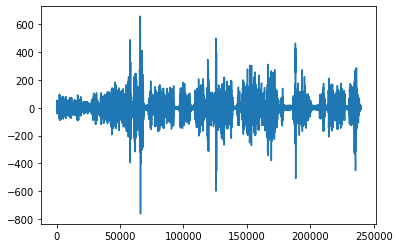

In [276]:
plt.plot(y.reshape(-1))

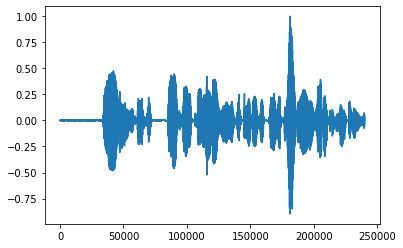

In [277]:
plt.plot(x)

In [302]:
IPython.display.Audio(x, rate=fs)

In [303]:
IPython.display.Audio(y, rate=fs)